In [2]:
NUM_FEATURES = 16
corrupted_files = {'2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_950296_M_D_CR_ME_CH12.wav'}

In [3]:
# LOADING STUFF IN!

from audio_file import AudioFile
import glob
import os
import random

audio_files_list = []

vehicle_types = {'B': 0, 'C': 0, 'M': 0, 'T': 0}

len_thing = 0
for og_file_path in glob.iglob('audiotrain/*.wav'):
  len_thing += 1
  file_path = os.path.basename(og_file_path)
  if file_path not in corrupted_files:
    audio = AudioFile(og_file_path)
    if not audio.is_background:
      v_type = audio.vehicle_type()
      if vehicle_types[v_type] < 1000:
        audio_files_list.append(audio)
        vehicle_types[v_type] += 1

In [4]:
vehicle_types

{'B': 70, 'C': 1000, 'M': 10, 'T': 766}

In [5]:
# DATASET SETUP!

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class VehicleDataset(Dataset):
    def __init__(self, audio_files, label_encoder):
        self.data = []
        self.labels = []

        print(f'This is about to take {round(len(audio_files)/200+1)} minutes.')

        for i, audio in enumerate(audio_files):
            try:
                x_info = audio.x_info()  # Frame-based feature arrays
                y_info = audio.y_info()  # Metadata including vehicle type
            
                # Stack the frame-based features

                features = np.stack([x_info[key] for key in sorted(x_info.keys())], axis=1)

                if i == 0:
                    global NUM_FEATURES
                    NUM_FEATURES = len(features)

                self.data.append(features)
                self.labels.append(label_encoder.transform([y_info['vehicle']])[0])
            except Exception as e:
                print(audio.path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)


In [6]:
# LABEL ENCODER & DATASET CREATION!

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit([af.y_info()['vehicle'] for af in audio_files_list])
dataset = VehicleDataset(audio_files_list, label_encoder)

This is about to take 10 minutes.


In [106]:
# NEURAL NETWORK DEFINITION!

import torch.nn as nn
import torch.nn.functional as F

class AudioClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.num_flattened_features = 32 * ((184 // 2) // 2)
        self.fc1 = nn.Linear(self.num_flattened_features, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [146]:
# TRAINING!
from torch.optim import Adam

model = AudioClassifier(16, num_classes=len(label_encoder.classes_))
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

loss_stats = []

def train_model(model, data_loader, epochs):
    model.train()
    for epoch in range(epochs):
        for features, labels in data_loader:
            features = features.permute(0, 2, 1)
            optimizer.zero_grad()
            outputs = model(features)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
        loss_stats.append(loss.item())
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
train_model(model, train_loader, epochs=100)


Epoch 1, Loss: 0.668711245059967
Epoch 2, Loss: 0.5440525412559509
Epoch 3, Loss: 0.4033713638782501
Epoch 4, Loss: 0.551994800567627
Epoch 5, Loss: 0.37524446845054626
Epoch 6, Loss: 0.5037959218025208
Epoch 7, Loss: 0.41292259097099304
Epoch 8, Loss: 0.15766629576683044
Epoch 9, Loss: 0.23382222652435303
Epoch 10, Loss: 0.2007959634065628
Epoch 11, Loss: 0.08373691886663437
Epoch 12, Loss: 0.14682826399803162
Epoch 13, Loss: 0.04551313817501068
Epoch 14, Loss: 0.11283814162015915
Epoch 15, Loss: 0.09505067020654678
Epoch 16, Loss: 0.02309093438088894
Epoch 17, Loss: 0.056660909205675125
Epoch 18, Loss: 0.07854081690311432
Epoch 19, Loss: 0.021813303232192993
Epoch 20, Loss: 0.005025203805416822
Epoch 21, Loss: 0.25212955474853516
Epoch 22, Loss: 0.01975673995912075
Epoch 23, Loss: 0.0061103771440684795
Epoch 24, Loss: 0.0021984465420246124
Epoch 25, Loss: 0.00974547490477562
Epoch 26, Loss: 0.02073066122829914
Epoch 27, Loss: 0.01557950209826231
Epoch 28, Loss: 0.0122291324660182
Epo

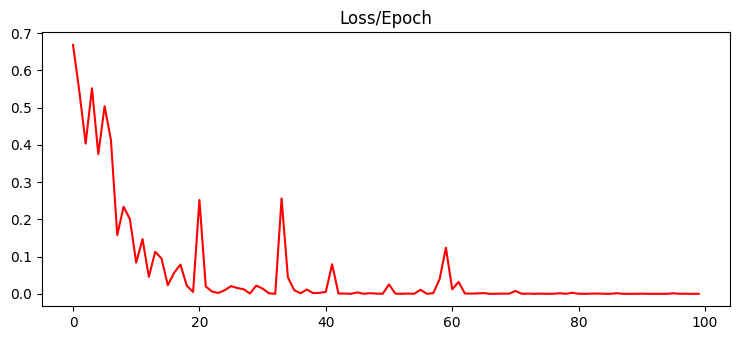

In [152]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
x = np.array(range(100))
y = np.array(loss_stats)

plt.title("Loss/Epoch")
plt.plot(x, y, color="red")

plt.show()

In [153]:
def predict_vehicle_type(af, model, file_path, label_encoder):
    x_info = af.x_info()
    y_info = af.y_info()
    
    features = np.stack([x_info[key] for key in sorted(x_info.keys())], axis=1)
    features = torch.tensor(features, dtype=torch.float32).unsqueeze(0)
    features = features.permute(0, 2, 1)

    model.eval()
    with torch.no_grad():
        output = model(features)
        prediction = torch.argmax(output, dim=1)
    
    predicted_label = label_encoder.inverse_transform(prediction.numpy())[0]
    
    actual_label = y_info['vehicle'] if 'vehicle' in y_info else 'Background'
    
    return predicted_label, actual_label

In [154]:
test_vehicle_types = {'B': 0, 'C': 0, 'M': 0, 'T': 0}
test_audio_files_list = []

for og_file_path in glob.iglob('audiotest/*.wav'):
  file_path = os.path.basename(og_file_path)
  if file_path not in corrupted_files:
    audio = AudioFile(og_file_path)
    if not audio.is_background:
      v_type = audio.vehicle_type()
      if test_vehicle_types[v_type] < 200:
        test_audio_files_list.append(audio)
        test_vehicle_types[v_type] += 1

random.shuffle(test_audio_files_list)

In [155]:
test_vehicle_types

{'B': 28, 'C': 200, 'M': 0, 'T': 192}

In [156]:
pred_stats = {'C': [0, 0], 'T': [0, 0], 'B': [0, 0], 'M': [0, 0]}
total_correct = 0
total_number = 0

for audio in test_audio_files_list:
  try:
    predicted, actual = predict_vehicle_type(audio, model, file_path, label_encoder)
    print(os.path.basename(file_path), end=' --> ')
    print(f'Predicted: {predicted}. Actual: {actual}. Accurate? {predicted == actual}.')
    total_number += 1
    total_correct += predicted==actual
    pred_stats[audio.vehicle_type()][0] += predicted==actual
    pred_stats[audio.vehicle_type()][1] += 1
  except Exception as e:
    print(f'Error with {os.path.basename(audio.path)}.')

print(f'{total_correct} out of {total_number}, with accuracy {round(total_correct/total_number * 100)}%.')

2019-11-19-15-25_Langewiesener-Strasse_50Kmh_2399853_A_D_CL_ME_CH12.wav --> Predicted: T. Actual: C. Accurate? False.
2019-11-19-15-25_Langewiesener-Strasse_50Kmh_2399853_A_D_CL_ME_CH12.wav --> Predicted: C. Actual: T. Accurate? False.
2019-11-19-15-25_Langewiesener-Strasse_50Kmh_2399853_A_D_CL_ME_CH12.wav --> Predicted: C. Actual: C. Accurate? True.
2019-11-19-15-25_Langewiesener-Strasse_50Kmh_2399853_A_D_CL_ME_CH12.wav --> Predicted: T. Actual: T. Accurate? True.
2019-11-19-15-25_Langewiesener-Strasse_50Kmh_2399853_A_D_CL_ME_CH12.wav --> Predicted: T. Actual: T. Accurate? True.
2019-11-19-15-25_Langewiesener-Strasse_50Kmh_2399853_A_D_CL_ME_CH12.wav --> Predicted: C. Actual: T. Accurate? False.
2019-11-19-15-25_Langewiesener-Strasse_50Kmh_2399853_A_D_CL_ME_CH12.wav --> Predicted: C. Actual: T. Accurate? False.
2019-11-19-15-25_Langewiesener-Strasse_50Kmh_2399853_A_D_CL_ME_CH12.wav --> Predicted: T. Actual: C. Accurate? False.
2019-11-19-15-25_Langewiesener-Strasse_50Kmh_2399853_A_D_CL

In [157]:
for key, value in pred_stats.items():
  print(f'For {key}: {value[0]}/{value[1]} correctly.')

For C: 102/196 correctly.
For T: 91/192 correctly.
For B: 11/28 correctly.
For M: 0/0 correctly.


Note that I tweaked the inputs to have at most 500 of each type of the 4 vehicles. This is because, as I started to get rates of above 90% before, I checked the prediction accuracy for each category AND found that it mostly just went with the CARs as default answers — trucks gets ignored, motorcycles don't even contribute to the error rate coz they have so little data.

So this is a controlled attempt to get the probability for each to be uniform. Now, for each category, the probability is between 40 to 55 percent. If we consider the probability of selecting AT RANDOM, each would have a correct probability of 1/4, which is 25 percent. This is still an improvement.